# add redshift failure weights to VAGC

In [1]:
import os
import h5py
import fitsio
import numpy as np
from tqdm import tqdm
from scipy.special import erf
import astropy.table as aTable

In [2]:
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask

In [4]:
import matplotlib.pyplot as plt

## read in target catalog

In [5]:
ff = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/fuji/LSScats/EDAbeta/BGS_ANY_full.dat.fits')

# select only BGS targets
is_bgs_bright = (
    (ff['COADD_FIBERSTATUS'] == 0) & 
    ((ff['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT']) != 0) & 
    (ff['SPECTYPE'] == 'GALAXY') & 
    (ff['Z_HP'] > 0.) & (ff['Z_HP'] < 0.6) & 
    (ff['ZWARN'] == 0) & 
    (ff['DELTACHI2'] > 40.) & 
    (ff['ZERR'] < 0.0005 * (1 + ff['Z_HP'])))

is_bgs_faint = (
    (ff['COADD_FIBERSTATUS'] == 0) & 
    ((ff['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_FAINT']) != 0) & 
    (ff['SPECTYPE'] == 'GALAXY') & 
    (ff['Z_HP'] > 0.) & (ff['Z_HP'] < 0.6) & 
    (ff['ZWARN'] == 0) & 
    (ff['DELTACHI2'] > 40.) & 
    (ff['ZERR'] < 0.0005 * (1 + ff['Z_HP'])))

print('%i BGS BRIGHT z-success' % np.sum(is_bgs_bright))
print('%i BGS FAINT z-success' % np.sum(is_bgs_faint))

143074 BGS BRIGHT z-success
96771 BGS FAINT z-success


## read in VAGC

In [6]:
fvagc = '/global/cfs/cdirs/desi/users/chahah/provabgs/svda/BGS_ANY_full.provabgs.hdf5'
vagc = aTable.Table.read(fvagc)
vagc[:5]

TARGETID,RA,DEC,Z_HP,ZERR,TSNR2_BGS,MAG_G,MAG_R,MAG_Z,MAG_W1,FIBMAG_R,HPIX_64,"provabgs_mcmc [100,13]",provabgs_theta_bf [13],provabgs_z_max,provabgs_logMstar_bf,provabgs_logMstar [100],col17,SCHLEGEL_COLOR
int64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,bytes14,float64
39633390185481181,191.17913199949842,60.25733587654764,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,SCHLEGEL_COLOR,-999.0
39633390164510024,188.6998080571996,60.21175772175424,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,SCHLEGEL_COLOR,-999.0
39633390185480955,191.14955067198017,60.34047183206205,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,SCHLEGEL_COLOR,-999.0
39633390185480938,191.14757099005186,60.345815959235,0.2819459922463374,2.191690764397e-05,1361.7778,20.420939956138607,19.440977833152942,18.807486906915823,18.725561063547207,21.083244145949642,11226,11.091623656909688 .. 0.3684622521221414,11.14249424405227 .. 0.3651476796540595,0.2891440449335749,10.894820213317871,10.848259925842285 .. 10.952618598937988,SCHLEGEL_COLOR,0.1059712957858181
39633416324383107,187.05117249536465,62.614542270156655,0.2703579310142208,0.00018002802349298926,1218.0295,20.876585604498494,19.373871860075226,18.567397256862876,18.32574859422363,20.212708263179056,11251,11.127879812361321 .. 0.6691898790548064,11.16028636319183 .. 0.6710591095679554,0.2822033708476234,10.909546852111816,10.877055168151855 .. 10.874772071838379,SCHLEGEL_COLOR,-0.3616078306686752


In [7]:
has_va = (vagc['provabgs_z_max'] != -999.)

In [8]:
vagc.add_column('provabgs_w_zfail')
vagc['provabgs_w_zfail'] = np.repeat(-999., len(vagc))

# assign weights to BGS Bright galaxies
using best-fit functions from `zfail_completeness.ipynb`

In [9]:
def fzsuccess_bright(rfib, tsnr): 
    ''' z-success rate as a function of r-band fiber magnitude and TSNR2
    for BGS Bright sample
    '''
    logtsnr = np.log10(tsnr)
    
    fz = np.ones(len(tsnr))
    for logtsnr0, logtsnr1, c_erf0, c_erf1 in zip([1.5, 2.0, 2.5, 3.0, 3.5, 3.85], 
                                                 [2.0, 2.5, 3.0, 3.5, 3.85, 5.0], 
                                                 [0.8, 0.85, 1.25, 0.9, 0.8, 0.65], 
                                                 [19.7, 21., 22.0, 22.5, 23.25, 21.5]):    
        
        logtsnr_lim = (logtsnr > logtsnr0) & (logtsnr < logtsnr1)
        if np.sum(logtsnr_lim) > 0: 
            fz[logtsnr_lim] = 0.5*(1-erf(c_erf0*(rfib[logtsnr_lim] - c_erf1)))
    return fz

In [10]:
fzsucc = fzsuccess_bright(vagc['FIBMAG_R'][is_bgs_bright], vagc['TSNR2_BGS'][is_bgs_bright])

Text(0, 0.5, '$\\log$ TSNR2')

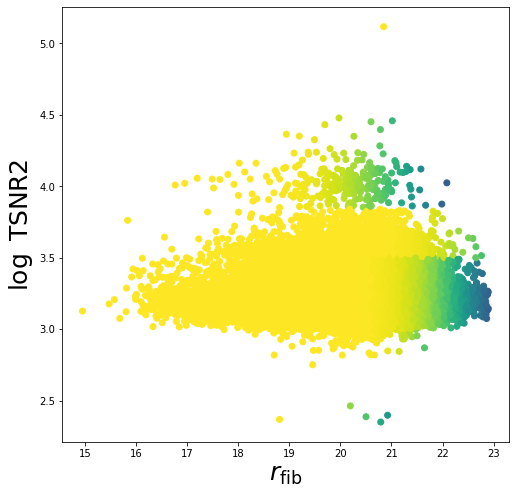

In [12]:
fig = plt.figure(figsize=(8,8))
sub = fig.add_subplot(111)
sub.scatter(vagc['FIBMAG_R'][is_bgs_bright], np.log10(vagc['TSNR2_BGS'][is_bgs_bright]), c=fzsucc, vmin=0., vmax=1.)
sub.set_xlabel(r'$r_{\rm fib}$', fontsize=25)
sub.set_ylabel(r'$\log$ TSNR2', fontsize=25)

In [13]:
vagc['provabgs_w_zfail'][is_bgs_bright] = 1./fzsucc

# assign $z$-fail weights to BGS Faint

In [14]:
def fzsuccess_faint_emline(rfib, tsnr): 
    ''' z-success rate for BGS Faint schlegel color > 0 (a.k.a. with emission lines)
    '''
    logtsnr = np.log10(tsnr)
    
    fz = np.ones(len(tsnr))
    for i, logtsnr0, logtsnr1, c_erf0, c_erf1 in zip(range(6), [1.5, 2.0, 2.5, 3.0, 3.5, 3.8],  
                                                     [2.0, 2.5, 3.0, 3.5, 3.8, 5.0], 
                                                     [3, 2, 1.25, 0.8, 0.8, 1.], 
                                                     [21., 21.25, 22.0, 23., 24, 21.6]):
        logtsnr_lim = (logtsnr > logtsnr0) & (logtsnr < logtsnr1)
        if i == 3: 
            c_erf0 = 1.0 + 0.6 * (logtsnr[logtsnr_lim] - 3.0)
            c_erf1 = 22.5 + 0.4 * (logtsnr[logtsnr_lim] - 3.0)
        if np.sum(logtsnr_lim) > 0: 
            fz[logtsnr_lim] = 0.5*(1-erf(c_erf0*(rfib[logtsnr_lim] - c_erf1)))
    return fz

def fzsuccess_faint_noemline(rfib, tsnr): 
    ''' z-success rate for BGS Faint schlegel color <= 0 (a.k.a. without emission lines)
    '''
    logtsnr = np.log10(tsnr)
    
    fz = np.ones(len(tsnr))
    for i, logtsnr0, logtsnr1, c_erf0, c_erf1 in zip(range(8), 
                                                 [2.5, 2.8, 3.0, 3.1, 3.2, 3.3, 3.5, 3.8], 
                                                 [2.8, 3.0, 3.1, 3.2, 3.3, 3.5, 3.8, 5.0], 
                                                 [5.0, 1.5, 2.5, 1.5, 0.85, 1.8, 0.8, 4.], 
                                                 [20.6, 21., 21.15, 21.7, 22.65, 21.7, 23, 20.6]): 
        logtsnr_lim = (logtsnr > logtsnr0) & (logtsnr < logtsnr1)
        if np.sum(logtsnr_lim) > 0: 
            fz[logtsnr_lim] = 0.5*(1-erf(c_erf0*(rfib[logtsnr_lim] - c_erf1)))
    return fz

In [15]:
faint_emline = is_bgs_faint & (vagc['SCHLEGEL_COLOR'] > 0.)
fzsucc_emline = fzsuccess_faint_emline(vagc['FIBMAG_R'][faint_emline], vagc['TSNR2_BGS'][faint_emline])

faint_noemline = is_bgs_faint & (vagc['SCHLEGEL_COLOR'] < 0.)
fzsucc_noemline = fzsuccess_faint_noemline(vagc['FIBMAG_R'][faint_noemline], vagc['TSNR2_BGS'][faint_noemline])

(2.3, 5.5)

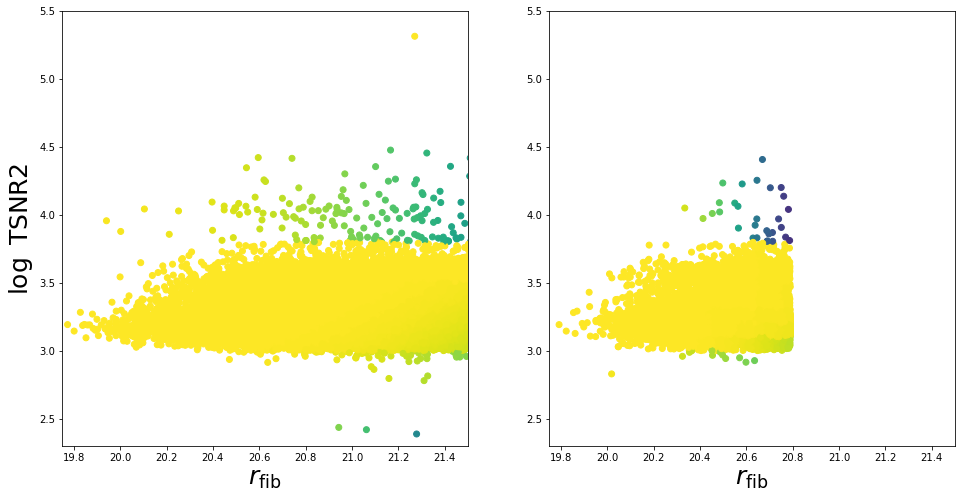

In [16]:
fig = plt.figure(figsize=(16,8))
sub = fig.add_subplot(121)
sub.scatter(vagc['FIBMAG_R'][faint_emline], np.log10(vagc['TSNR2_BGS'][faint_emline]), 
            c=fzsucc_emline, vmin=0., vmax=1.)
sub.set_xlabel(r'$r_{\rm fib}$', fontsize=25)
sub.set_xlim(19.75, 21.5)
sub.set_ylabel(r'$\log$ TSNR2', fontsize=25)
sub.set_ylim(2.3, 5.5)

sub = fig.add_subplot(122)
sub.scatter(vagc['FIBMAG_R'][faint_noemline], np.log10(vagc['TSNR2_BGS'][faint_noemline]), 
            c=fzsucc_noemline, vmin=0., vmax=1.)
sub.set_xlabel(r'$r_{\rm fib}$', fontsize=25)
sub.set_xlim(19.75, 21.5)
sub.set_ylim(2.3, 5.5)

In [17]:
vagc['provabgs_w_zfail'][faint_emline] = 1./fzsucc_emline
vagc['provabgs_w_zfail'][faint_noemline] = 1./fzsucc_noemline

In [20]:
vagc.write(fvagc, overwrite=True)

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/astropy/io/misc/hdf5.py:283: UserWarning: table path was not set via the path= argument; using default path __astropy_table__
  "using default path {}".format(path))
